# Global Optimization

Author: Michael Greer

This notebook seeks to implement the methods presented in "Advanced Robotics: Redundancy and Optimization", section 5.7 regarding optimization of a robotic pose through a path.

In [46]:
import numpy as np
from numpy import cos, sin, pi

import matplotlib.pyplot as plt

from scipy.linalg import null_space

import sympy as sp

In [47]:
def plot_robot(links, joints, path):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    xs = [0]
    ys = [0]
    
    total_len = sum(links)
    
    total_q = 0
    
    for l,q in zip(links, joints):
        
        total_q += q
        
        xs.append(xs[-1] + l * cos(total_q))
        ys.append(ys[-1] + l * sin(total_q))
        
    plt.figure(figsize=(8,8))
    plt.plot(xs, ys)
    plt.ylim(-1 * total_len, total_len)
    plt.xlim(-1 * total_len, total_len)
    plt.title('Robot Manipulator Pose')
    
    plt.plot([path.p1[0], path.p2[0]], [path.p1[1], path.p2[1]])
    
    return

In [48]:
# Defines a linear paramaterized path through 2d space using the start and end points and the end time of the path

class Path():
    
    p1 = np.array([0, 0])
    p2 = np.array([0, 0])
    
    t_fin = 0
    
    def __init__(self, p1, p2, t_fin):
        
        self.p1 = p1
        self.p2 = p2
        
        self.t_fin = t_fin
        
        return
    
    def get_pos(self, t):
        
        pos = self.p1 + (t / self.t_fin) * (self.p2 - self.p1)
        
        return pos
    
    # The velocity is independant of t
    def get_vel(self):
        
        vel = (self.p2 - self.p1) / self.t_fin
        
        return vel

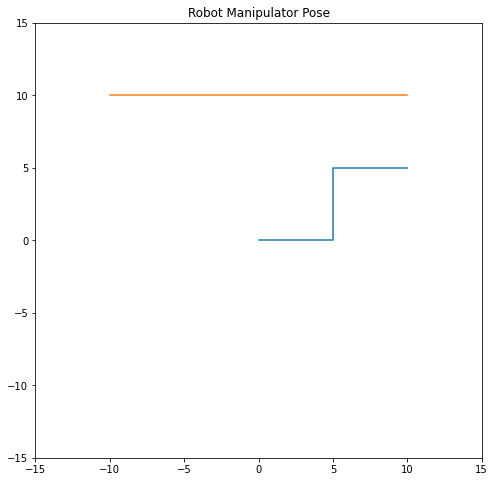

In [49]:
# Change the joint values to see how the arm moves

newpath = Path(np.array([10,10]), np.array([-10,10]), 1)
plot_robot([5, 5, 5], [0, pi/2, -pi/2], newpath)

In [50]:
def f_kine(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    x = 0
    y = 0
    
    total_len = sum(links)
    
    total_q = 0
    
    for l,q in zip(links, joints):
        
        total_q += q
        
        x += l * cos(total_q)
        y += l * sin(total_q)
        
    return np.array([[x],[y]])

In [51]:
def jacobian(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
            
    # Form symbolic q matrix
    
    qs = []
    
    for i in range(0,len(joints)):
        
        qs.append(sp.Symbol('q{}'.format(i)))
        
        
    jac = np.zeros((2, len(links)))
    
    x = 0
    y = 0
    
    # Form forward kinematics
    for i in range(len(links)):
                   
        total_q = 0
        
        for j in range(i + 1):
            
            total_q += qs[j]
            
        x += links[i] * sp.cos(total_q)
        y += links[i] * sp.sin(total_q)
        
    
    # Differentiate to find jacobian      
    for i in range(len(links)):
        
        Jx = sp.diff(x, qs[i])
        Jy = sp.diff(y, qs[i])
        
        for k in range(len(links)):
            
            Jx = Jx.subs(qs[k], joints[k])
            Jy = Jy.subs(qs[k], joints[k])
                
        jac[0,i] = Jx.evalf()
        jac[1,i] = Jy.evalf()
            
    return jac

In [52]:
# Note: this ONLY works for targets within the workspace. For points outside the workspace this function will not exit
# We need this to solve the initial configuration of the manipulator
# Note: this ONLY works for targets within the workspace. For points outside the workspace this function will not exit
# q_des is the desired joint values that the i_kine should optimize for
# q_des_mask tells the function which joints we care about. Used for only specifying motion for select joints.
def i_kine_null(links, joints, target, q_des, q_des_mask, error_trace=False):
    
    current_q = joints
    
    # This term limits the maximum delta x per move
    max_move = 2
    
    e_trace = []
    
    while(1):
        
        # Get the current end effector position
        current_x = f_kine(links, current_q)
        
        # Get the vector to the target
        delta_x = target - current_x
        
        # Find the magnitude of the movement required
        delta_x_norm = np.linalg.norm(delta_x)
        
        e_trace.append(delta_x_norm)
        
        # Limit the maximum magnitude of delta_x
        if (delta_x_norm > max_move):
            
            delta_x /= (delta_x_norm / max_move)
            
        q_err = np.multiply(q_des - current_q, q_des_mask)    
            
        
        jac = jacobian(links, current_q)
        
        # Jacobian pseudoinversion
        jac_pinv = np.linalg.pinv(jac)
        
        # Null space of jacobian, and projection matrix
        # We just use the scipy function to find it, much faster than solving it ourselves
        jac_null = null_space(jac)
        
        null_project = jac_null @ np.linalg.inv(jac_null.T @ jac_null) @ jac_null.T
        
        # Find the required movements in the joint space
        alpha = 0.8
        beta = 0.8
                
        delta_q = alpha * jac_pinv @ delta_x + beta * (null_project @ q_err)
        
        # Add the change to find the updated joint angles
        current_q += delta_q
        
        # Stop if the end effector is sufficently close to task target and joint target
        if (delta_x_norm < 0.0001 and np.linalg.norm(delta_q) < 0.001):
            
            break
        
    return (current_q, e_trace) if error_trace else current_q

In [53]:
from runge_kutta_step import *

def g(links, joints, psi, path):
    
    jac = jacobian(links, joints)
    
    jac_pinv = jac.T @ np.linalg.inv(jac @ jac.T)
            
    return jac_pinv @ path.get_vel() + 0.5 * (np.eye(len(joints)) - jac_pinv@jac) @ psi


# Found using finite change method, too lazy to actually derive this right now
def dg_dq(links, joints, psi, path):
    
    grad = np.zeros((len(joints),len(joints)))
    
    for i in range(len(joints)):
        
        dq = np.zeros((len(joints),1))
        
        dq[i] = 1e-15
        
        dg = g(links, joints + dq, psi, path) - g(links, joints, psi, path)
                
        grad[i,:] = dg.reshape((len(joints),))/1e-15
        
    return grad


def dydt(y, t, *args):
        
    args = args[0]
        
    links = args[0]
    
    path = args[1]
    
    q = y[0:len(links)]
    
    psi = y[len(links):]
    
    q_dot = g(links, q, psi, path)
        
    psi_dot = dg_dq(links, q, psi, path).T @ (2 * g(links, q, psi, path) - psi)
    
    y_dot = np.vstack((q_dot, psi_dot))
    
    #print(y_dot)
    
    return y_dot

In [ ]:
# We are testing a series of initial configurations to see which ones will have the relevant metrics closest to zero
angle_min = -1.8
angle_max = 1.8

final_angles = []
trans_cond_list = []

for i, angle in enumerate(np.linspace(angle_min, angle_max, num=100)):
    
    if (i % 10 == 0):
        
        print(i)

    # We are stepping backwards from the end to the start
    h = -0.005

    path = Path(np.array([[5],[7]]), np.array([[-5],[10]]), 1)

    links = [5, 5, 5]

    joints = np.array([[-pi], [0.0], [0.0]])

    target_joints = np.array([[0.0], [angle], [0.0]])

    target_joints_mask = np.array([[0.0], [1.0], [0.0]])

    final_joints = i_kine_null(links, joints, path.p2, target_joints, target_joints_mask)

    #plot_robot(links, final_joints, path)

    final_psi = np.zeros((len(joints),1))

    y = np.vstack((final_joints, final_psi))

    t = path.t_fin
    
    js_path_length = 0

    while (t >= 0):

        #print("Time: {}".format(t))
        
        y_prev = y

        (y, t) = runge_kutta_step(dydt, y, t, h, links, path)
        
        q_dot = y[0:len(joints)] - y_prev[0:len(joints)]
        
        js_path_length += q_dot.T @ q_dot


    #plot_robot(links, y[0:len(joints)], path)

    initial_psi = y[len(joints):]

    initial_joints = y[0:len(joints)]

    jac = jacobian(links, initial_joints)

    jac_pinv = jac_pinv = jac.T @ np.linalg.inv(jac @ jac.T)

    trans_cond = (np.eye(len(joints)) - jac_pinv@jac) @ initial_psi

    print("Run for final configuration:\n{}".format(final_joints))
    print("Transversatility condition is: {}".format(np.linalg.norm(trans_cond)))
    print("Joint Space path length is: {}".format(js_path_length))
    
    final_angles.append(final_joints[1,0])
    trans_cond_list.append(np.linalg.norm(trans_cond))

plt.figure()
plt.plot(final_angles, trans_cond_list)
plt.show()

0


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-54-75265dd61962>", line 45, in <module>
    (y, t) = runge_kutta_step(dydt, y, t, h, links, path)
  File "/home/michaelgreer/Documents/Instructional/inverse_kinematics/runge_kutta_step.py", line 13, in runge_kutta_step
    k4 = dydt(y + h*k3, t + h, args)
  File "<ipython-input-53-123d80156cf4>", line 44, in dydt
    psi_dot = dg_dq(links, q, psi, path).T @ (2 * g(links, q, psi, path) - psi)
  File "<ipython-input-53-123d80156cf4>", line 23, in dg_dq
    dg = g(links, joints + dq, psi, path) - g(links, joints, psi, path)
  File "<ipython-input-53-123d80156cf4>", line 5, in g
    jac = jacobian(links, joints)
  File "<ipython-input-51-74888f273d8c>", line 38, in jacobian
    Jy = sp.diff(y, qs[i])
  File "/usr/local/lib/python3.9/dist-packages/sympy/core/function.py", line 2491, in

In [56]:
# Now, we try and do the same thing but with dampening on the second joint

from runge_kutta_step import *

def g(links, joints, psi, path):
    
    jac = jacobian(links, joints)
    
    damp = np.array([0, 1, 0])
    
    damp = np.diag(damp)
    
    jac_pinv = np.linalg.inv(jac.T @ jac + damp) @ jac.T
    
    #print(jac_pinv @ path.get_vel())
            
    return jac_pinv @ path.get_vel() + 0.5 * (np.eye(len(joints)) - jac_pinv@jac) @ psi


# Found using finite change method, too lazy to actually derive this right now
def dg_dq(links, joints, psi, path):
    
    grad = np.zeros((len(joints),len(joints)))
    
    for i in range(len(joints)):
        
        dq = np.zeros((len(joints),1))
        
        dq[i] = 1e-8
        
        dg = g(links, joints + dq, psi, path) - g(links, joints, psi, path)
                
        #dg[1] = 0 # We have to force this to be zero due to some numerical issues
                
        grad[i,:] = dg.reshape((len(joints),))/1e-8
        
    #print(grad)
            
    return grad


def dydt(y, t, *args):
        
    args = args[0]
        
    links = args[0]
    
    path = args[1]
    
    q = y[0:len(links)]
    
    psi = y[len(links):]
    
    q_dot = g(links, q, psi, path)
        
    psi_dot = dg_dq(links, q, psi, path).T @ (2 * g(links, q, psi, path) - psi)
    
    y_dot = np.vstack((q_dot, psi_dot))
    
    #print(y_dot)
    
    return y_dot

0
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832004]
[-1.49832004]
[-1.49832004]
[-1.49832004]
[-1.49832004]
[-1.49832004]
[-1.49832004]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.49832003]
[-1.

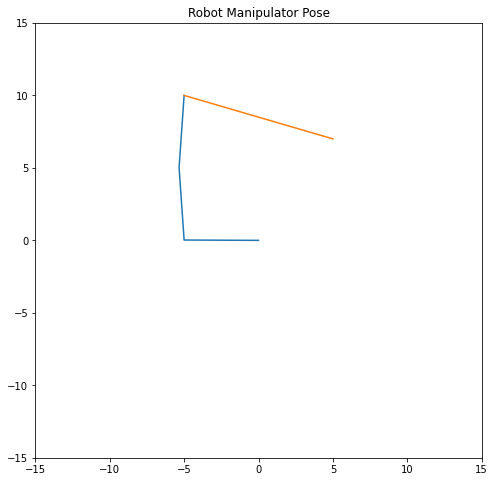

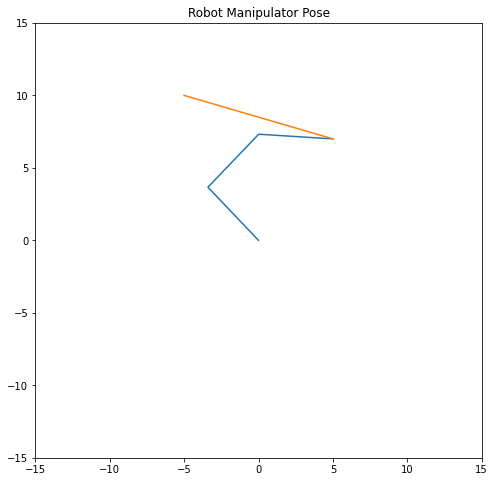

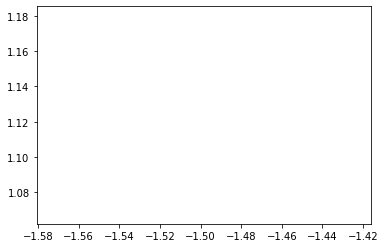

In [57]:
# We are testing a series of initial configurations to see which ones will have the relevant metrics closest to zero
angle_min = -1.5
angle_max = -1.5

final_angles = []
trans_cond_list = []

for i, angle in enumerate(np.linspace(angle_min, angle_max, num=1)):
    
    if (i % 10 == 0):
        
        print(i)

    # We are stepping backwards from the end to the start
    h = -0.005

    path = Path(np.array([[5],[7]]), np.array([[-5],[10]]), 1)

    links = [5, 5, 5]

    joints = np.array([[-pi], [0.0], [0.0]])

    target_joints = np.array([[0.0], [angle], [0.0]])

    target_joints_mask = np.array([[0.0], [1.0], [0.0]])

    final_joints = i_kine_null(links, joints, path.p2, target_joints, target_joints_mask)

    plot_robot(links, final_joints, path)

    final_psi = np.zeros((len(joints),1))

    y = np.vstack((final_joints, final_psi))

    t = path.t_fin
    
    js_path_length = 0

    while (t >= 0):

        #print("Time: {}".format(t))
        
        y_prev = y

        (y, t) = runge_kutta_step(dydt, y, t, h, links, path)
        
        q_dot = y[0:len(joints)] - y_prev[0:len(joints)]
        
        js_path_length += q_dot.T @ q_dot
        
        print(y[1])


    plot_robot(links, y[0:len(joints)], path)

    initial_psi = y[len(joints):]

    initial_joints = y[0:len(joints)]

    jac = jacobian(links, initial_joints)

    jac_pinv = jac_pinv = jac.T @ np.linalg.inv(jac @ jac.T)

    trans_cond = (np.eye(len(joints)) - jac_pinv@jac) @ initial_psi

    print("Run for final configuration:\n{}".format(final_joints))
    print("Transversatility condition is: {}".format(np.linalg.norm(trans_cond)))
    print("Joint Space path length is: {}".format(js_path_length))
    
    final_angles.append(final_joints[1,0])
    trans_cond_list.append(np.linalg.norm(trans_cond))

plt.figure()
plt.plot(final_angles, trans_cond_list)
plt.show()